In [1]:
import cv2
import ast
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getBoxesIntersect(boxA, boxB):
        if boxA[0] > boxB[2]:
            return False  # boxA is right of boxB
        if boxB[0] > boxA[2]:
            return False  # boxA is left of boxB
        if boxA[3] < boxB[1]:
            return False  # boxA is above boxB
        if boxA[1] > boxB[3]:
            return False  # boxA is below boxB
        return True

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
    return float(area_A + area_B - interArea)

def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

def get_iou(boxA, boxB):
    if getBoxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    iou = interArea / union
    assert iou >= 0
    return iou

In [3]:
IOUThreshold = 0.5

def get_miou(pred_bboxes, gt_bboxes):
    # Get only detection of class c
    dects = pred_bboxes
    FP_boxes = []
    
    iou_sum = 0
    TP = 0
    gt_usablecheck = [True] * len(gt_bboxes)
    for d in range(len(dects)):
        gt = gt_bboxes
        iouMax = 0
        for j in range(len(gt)):
            iou = get_iou(dects[d], gt[j])
            if iou > iouMax:
                iouMax = iou
                jmax = j

        if iouMax >= IOUThreshold:
            if gt_usablecheck[jmax]:
                gt_usablecheck[jmax] = False
                iou_sum += iouMax
                TP += 1
            else:
                FP_boxes.append(dects[d])
        else:
            FP_boxes.append(dects[d])
        
    num = len(pred_bboxes) + len(gt_bboxes) - TP
    return (iou_sum, num, TP, FP_boxes)

In [13]:
def get_info(model_name, mixed_image_name):
    det_log = './outputs/det_logs/'+mixed_image_name+'_'+model_name+'.log'
    with open(det_log, 'r') as f:
        boxes = f.readline()
        boxes = ast.literal_eval(boxes)[0]
        confs = f.readline()
        confs = ast.literal_eval(confs)[0]
        classes = f.readline()
        classes = ast.literal_eval(classes)[0]
    pred_bboxes = []
    for c, conf, box in zip(classes, confs, boxes):
        if int(c) == 0:
            b = [int(800*float(p)) for p in box]
            b = [b[1], b[0], b[3], b[2], float(conf)]
            pred_bboxes.append(b)

    size_key = 'size50to150'
    gt_log = './data/dataset/coco_mixed_val.txt'
    with open(gt_log, 'r') as f:
        gts = f.readlines()
    for i in range(len(gts)):
        line = gts[i]
        if size_key in line and mixed_image_name in line:
            gt_bboxes = line.rsplit()[1:]
            gt_bboxes = [[int(e) for e in gt_bbox.split(',')] for gt_bbox in gt_bboxes]
    iou_sum, num, TP, FP_boxes = get_miou(pred_bboxes, gt_bboxes)
    return (iou_sum, num, TP, len(gt_bboxes), pred_bboxes, FP_boxes)

In [24]:
mixed_image_names = ['mix000000', 'mix000001', 'mix000002', 'mix000003', 'mix000004']
model_names = ['ckpt_0000_1', 'ckpt_0001_1', 'ckpt_00005', 'ckpt_0101_1', 'ckpt_0101',  
              'ckpt_0303_1', 'ckpt_0303', 'ckpt_0307', 'ckpt_0703', 'ckpt_1010', 'default']
model_miou_list = []
for model_name in model_names:
    model_miou_sum = 0
    for mixed_image_name in mixed_image_names:
        iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)
        miou = iou_sum/num
        model_miou_sum += miou    
    model_miou_list.append([model_name, model_miou_sum/len(mixed_image_names)])
model_miou_list = sorted(model_miou_list, key=lambda x: x[1], reverse=True)
for mm in model_miou_list:
    print(mm)

['ckpt_0101_1', 0.23558411390587417]
['ckpt_0303', 0.2341103891491852]
['ckpt_0703', 0.2334943948301683]
['ckpt_0307', 0.23330578909436114]
['ckpt_0101', 0.23304436581836718]
['ckpt_1010', 0.22825077145278225]
['ckpt_0303_1', 0.22680399151872593]
['ckpt_0001_1', 0.2105378184875138]
['default', 0.18285874614049166]
['ckpt_00005', 0.12690992141112775]
['ckpt_0000_1', 0.07448621327625475]


# Check Prediction bboxes

In [6]:
def draw_bbox(image, bboxes, linecolor=(255, 0, 0)):
    for b in bboxes:
        c1, c2 = (b[0], b[1]), (b[2], b[3])
        cv2.rectangle(image, c1, c2, linecolor, 2)
    return image

In [27]:
def visualize(model_name, mixed_image_name):
    iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)

    original_image = cv2.imread('./data/mixed_images/'+mixed_image_name+'.png')
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image = draw_bbox(original_image, pred_bboxes)
    image = draw_bbox(image, fp_boxes, (0, 255, 0))

    plt.figure(figsize=(12,12))
    plt.title(model_name+' '+mixed_image_name)
    plt.imshow(image)
    plt.show()
    
    print(model_name, mixed_image_name)
    print('pd_boxes',len(pred_bboxes))
    print('gt_boxes',gt_len)
    print('TP',TP)
    print('FP',len(fp_boxes))
    print('num',num)
    print('fp_boxes', fp_boxes)
    print('miou',iou_sum/num) 

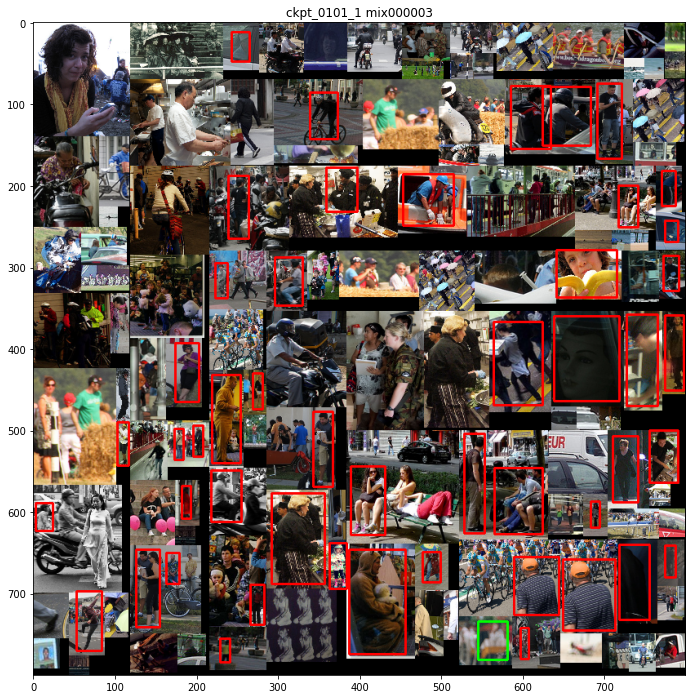

ckpt_0101_1 mix000003
pd_boxes 50
gt_boxes 219
TP 49
FP 1
num 220
fp_boxes [[545, 734, 581, 781, 0.7918720841407776]]
miou 0.18885474244362188


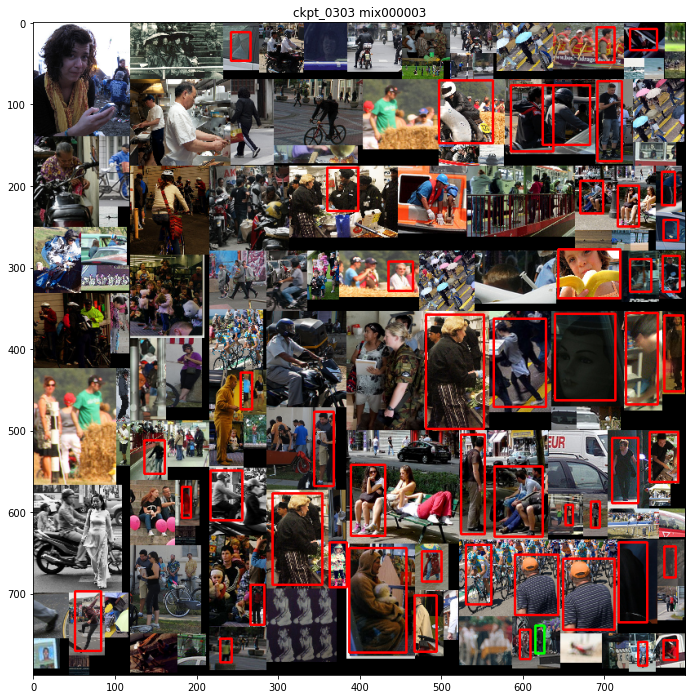

ckpt_0303 mix000003
pd_boxes 50
gt_boxes 219
TP 49
FP 1
num 220
fp_boxes [[615, 739, 626, 773, 0.7030745148658752]]
miou 0.1848429031317263


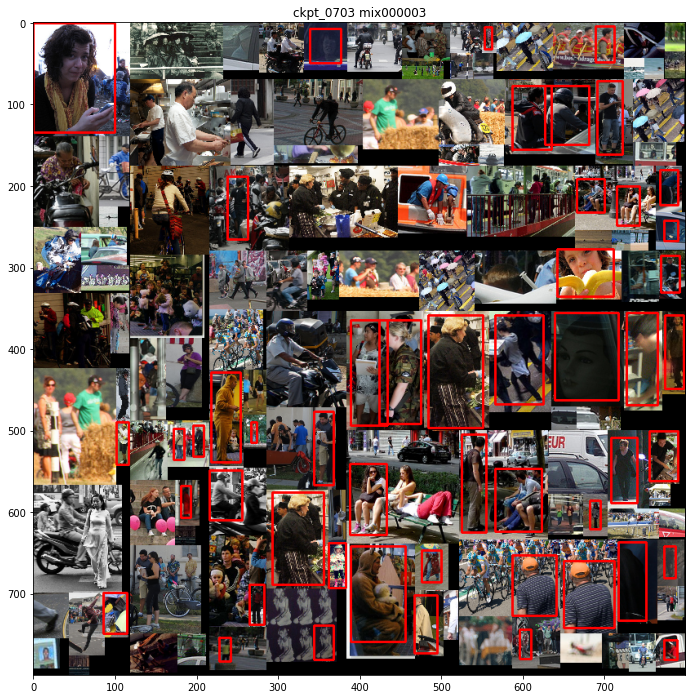

ckpt_0703 mix000003
pd_boxes 50
gt_boxes 219
TP 50
FP 0
num 219
fp_boxes []
miou 0.19233152604355466


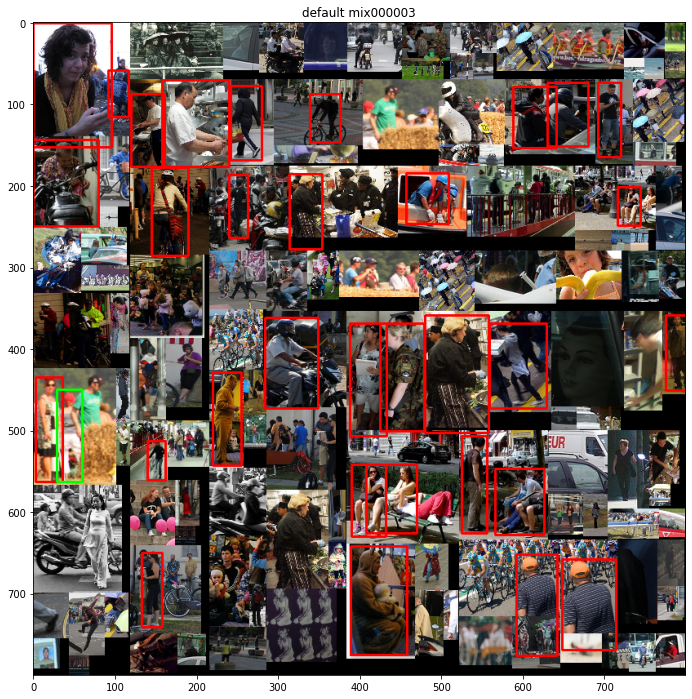

default mix000003
pd_boxes 33
gt_boxes 219
TP 32
FP 1
num 220
fp_boxes [[29, 450, 60, 563, 0.495877206325531]]
miou 0.12056786401589163


In [29]:
selected_models = ['ckpt_0101_1', 'ckpt_0303', 'ckpt_0703', 'default']
mixed_image_name = 'mix000003'
for model_name in selected_models:
    visualize(model_name, mixed_image_name)

In [20]:
def get_gt_bboxes(mixed_image_name):
    size_key = 'size50to150'
    gt_log = './data/dataset/coco_mixed_val.txt'
    with open(gt_log, 'r') as f:
        gts = f.readlines()
    for i in range(len(gts)):
        line = gts[i]
        if size_key in line and mixed_image_name in line:
            gt_bboxes = line.rsplit()[1:]
            gt_bboxes = [[int(e) for e in gt_bbox.split(',')] for gt_bbox in gt_bboxes]
    return gt_bboxes

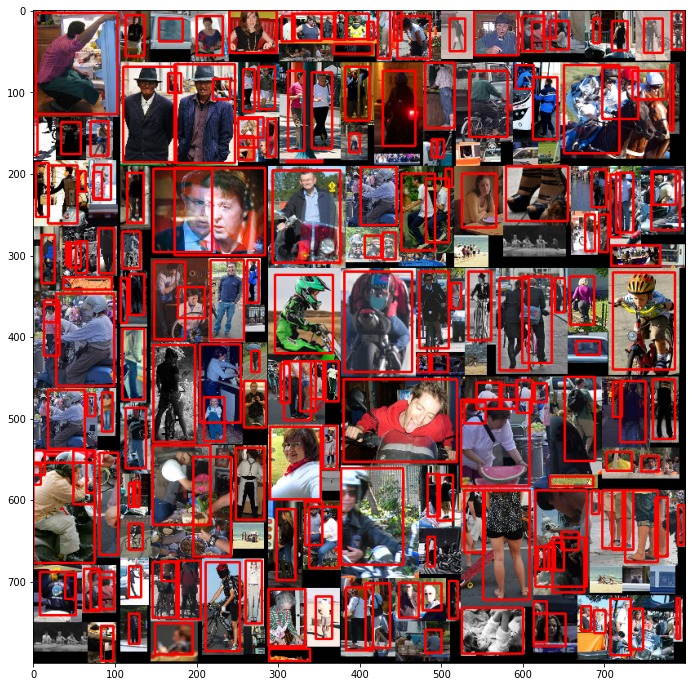

In [22]:
original_image = cv2.imread('./data/mixed_images/'+mixed_image_name+'.png')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
gt_bboxes = get_gt_bboxes(mixed_image_name)
image = draw_bbox(original_image, gt_bboxes)
plt.figure(figsize=(12,12))
plt.imshow(image)